In [5]:
#imports
import pandas as pd
from datetime import datetime as dtime
import numpy as np
from scipy.stats import kurtosis, skew
from sklearn.ensemble import RandomForestClassifier


# LabEvents

In [6]:

def getLabEventsByItemID(itemID):
    filterDF = labevents['ITEMID'] == itemID
    PatientsDataFrame = labevents[filterDF]

    # printing the first few rows of the dataset
    
    PatientsDataFrame.head()
    return PatientsDataFrame

# Getting all info associated to one patient
def getInfoBySubjectID(dfToFilter,patientID):
    filterDF = dfToFilter['SUBJECT_ID'] == patientID
    df = dfToFilter[filterDF]
    return df


# CSV and Data Validation

In [7]:

# Reading CSV file

patients = pd.read_csv("D:/1_Swansea/1_Uni/1_Project/Understanding/dataset/PATIENTS.csv")
admissions = pd.read_csv("D:/1_Swansea/1_Uni/1_Project/Understanding/dataset/ADMISSIONS.csv")
labevents = pd.read_csv("D:/1_Swansea/1_Uni/1_Project/Understanding/dataset/LABEVENTS.csv")

# Recording creatinine data
creatinineDF = getLabEventsByItemID(50912)
patientsWithCreatinineScans = creatinineDF['SUBJECT_ID']

# Data validation

admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME']).dt.date
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])
patients['DOB'].astype(str)
admissions['ADMITTIME'].astype(str)

patientArray = admissions.loc[:,'SUBJECT_ID']
print(patientArray)


0           22
1           23
2           23
3           24
4           25
         ...  
58971    98800
58972    98802
58973    98805
58974    98813
58975    98813
Name: SUBJECT_ID, Length: 58976, dtype: int64


# Data Preprocessing

In [8]:
# Estimated Glomerular Filtration Rate (eGFR) differ between genders and ethnicities
# This code adjusts for these differences by introducing the MDRD equation
# Only for CKD not accurate for acute renal failure
# MDRD EQUATION: eGFR (mL/min/1.73 m2) = 175 × (Scr)-1.154 × (Age)-0.203 × (0.742 if female) × (1.212 if African American)

def mdrdEquation(serumCreatinine, age, gender, africanAmerican):
    genderModifier = 0
    africanAmerican = 0

    # if 'M' gender modifier is ignored

    if gender == 'F':
        genderModifier = 1

    # if not "africanAmerican", this is ignored

    if africanAmerican:
        africanAmerican = 1
    eGFR = (175 * (serumCreatinine) ** (-1.545)) * ((age) ** (-0.203)) * (0.742 * genderModifier) * (
                1.212 * africanAmerican)

# Labelling patient by baseline creatinine level to assign to a CKD/AKI stage as defined in the literature
# scanData -> the creatinine data array

def labelPatient(scanData,BaseLineCreatinine):
    stage = 0
    for scan in scanData:
        if scan > 1.5*BaseLineCreatinine and scan < 2.0*BaseLineCreatinine and stage < 1:
            stage = 1
        if scan >= 2.0*BaseLineCreatinine and scan < 3.0*BaseLineCreatinine and stage < 2:
            stage = 2
        if scan >= 3.0*BaseLineCreatinine and stage < 3:
            stage = 3
        return stage

# Calculation of baseline creatinine
# Baseline Creatinine= 0.74 − 0.2 (if female) + 0.08 (if black) + 0.003 × age (in years)

def baseLineCreatinine(age,gender,africanAmerican):
    genderModifier = 0
    africanAmerican = 0
    if gender == 'F':
        genderModifier = 1
    if africanAmerican:
        africanAmerican = 1
    baseLineCreatinine = 0.74 - 0.2 * genderModifier + 0.08 * africanAmerican + 0.003 *  age
    return baseLineCreatinine

# Processing the ethnicity of the patient
# for use in baseline creatinine function

def processEthnicity(ethnicity):
    if ethnicity == "BLACK/AFRICAN" or ethnicity == "BLACK/AFRICAN AMERICAN" or ethnicity == "BLACK/AFRICAN AMERICAN" or ethnicity == "BLACK/CAPE VERDEAN" or ethnicity == "BLACK/HAITIAN":
        return 1
    else:
        return 0

# Retrieving patient data

def getCreatinineScans(patientID):
    filterDF = creatinineDF['SUBJECT_ID'] == patientID
    patientData = creatinineDF[filterDF]
    patientData = patientData[['CHARTTIME','VALUENUM']]
    patientData = patientData.sort_values(by=['CHARTTIME'])
    return patientData

# Calculating the peak, variance, average,
# standard deviation, skewness, and kurtosis
# of the patient creatinine data


def peakOfData(scanData):
    mx = 0
    for i in scanData:
        mx = max(mx,i)
    return mx

def varianceOfData(scanData):
    var = np.var(scanData)
    return var

def averageOfData(scanData):
    average = np.average(scanData)
    return average

def stdDeviationOfData(scanData):
    stDeviation = np.std(scanData)
    return stDeviation

def skewnessOfData(scanData,n):
    var = varianceOfData(scanData)
    mean = averageOfData(scanData)
    factor = (1/n*(mean)**3)
    summation = 0
    for i in scanData:
        summation += (i-mean)**3
    return factor*summation

def kurtosisOfData(scanData,n):
    var = varianceOfData(scanData)
    mean = averageOfData(scanData)
    factor = (1/n*(mean)**4)
    summation = 0
    for i in scanData:
        summation += (i-mean)**4
    return factor*summation


# Processing patients


In [9]:

def processPatients(labevents, admissions, patients):
    # Creating DataFrame of patient

    f = pd.DataFrame(columns=['SUBJECT_ID', 'LABEL', 'BASELINECREATININE', 'ETHNICITY', 'AGE', 'CREATININEPEAK',
                              'CREATININEVARIANCE', 'CREATININEAVERAGE', 'CREATININESTDDEVIATION', 'CREATININESKEWNESS',
                              'CREATININEKURTOSIS'])

    for patientID in patientArray:

        # Creatinine data for patients
        creatinineScansDF = getInfoBySubjectID(creatinineDF, patientID)

        # Admission data for patient
        admissionsDF = getInfoBySubjectID(admissions, patientID)

        # Patient data
        patientDF = getInfoBySubjectID(patients, patientID)

        # Retrieving the values of the creatinine scans
        creatinineScansValuesDF = creatinineScansDF['VALUE']

        # Gives the patient ethinicity as a string
        patientEthnicity = processEthnicity(admissionsDF['ETHNICITY'].to_string)

        # Gives the patient gender as a string
        patientGender = patientDF['GENDER'].to_string()

        # Gives the patients date of birth as a string
        # split() -> patient DOB split on whitespace
        # [1] gives the start index of the DOB
        patientDateOfBirth = patientDF['DOB'].to_string()
        patientDateOfBirth = patientDateOfBirth.split()
        patientDateOfBirth = patientDateOfBirth[1]

        # Gives the patients admission time as a string
        # split() -> patient admission split on whitespace
        # [1] gives the start index of the admission time
        patientAdmissionTime = admissionsDF['ADMITTIME'].to_string()
        patientAdmissionTime = patientAdmissionTime.split()
        patientAdmissionTime = patientAdmissionTime[1]

        # strptime() creates datetime object from string
        dateOfBirth = dtime.strptime(patientDateOfBirth, '%Y-%m-%d')
        admissionTime = dtime.strptime(patientAdmissionTime, '%Y-%m-%d')

        # Retrieving creatinine patient DataFrame
        patientCreatinineDF = getCreatinineScans(patientID)

        # Getting all values in the VALUENUM column
        creatinineDataArray = patientCreatinineDF.loc[:, 'VALUENUM']

        # Calulating number of days between two dates and dividing by 365 to give patient age at admission
        patientAge = (admissionTime - dateOfBirth).days // 365

        # If the length of the creatinine data array is greater than 4, and 18 < patient age < 80...
        if len(creatinineDataArray > 4) and patientAge < 80 and patientAge > 18:
            # Calculating baseline creatinine for the patient
            patientBaseLineCreatinine = baseLineCreatinine(patientAge, patientGender, patientEthnicity)

            # Labelling the patient
            patientLabel = labelPatient(creatinineDataArray, patientBaseLineCreatinine)

            # Creatinine statistics
            creatininePeak = peakOfData(creatinineDataArray)
            creatinineVariance = varianceOfData(creatinineDataArray)
            creatinineAverage = averageOfData(creatinineDataArray)
            creatinineStdDeviation = stdDeviationOfData(creatinineDataArray)
            creatinineSkewness = skewnessOfData(creatinineDataArray, len(creatinineDataArray))
            creatinineKurtosis = kurtosisOfData(creatinineDataArray, len(creatinineDataArray))

            # patientRow = {'SUBJECT_ID':patientID,'LABEL':patientLabel,'BASELINECREATININE':patientBaseLineCreatinine,'ETHNICITY':patientEthnicity=="WHITE",'AGE':patientAge,'CREATININEPEAK':creatininePeak,'CREATININEVARIANCE':ceratinineVariance,'CREATININEAVERAGE':creatinineAverage,'CRETININESTDDEVIATION':creatinineStdDeviation,'CREATININESKEWNESS':creatinineSkewness,'CREATININEKURTOSIS':creatinineKurtosis}
            # f = f.append(patientRow,ignore_index=True)

            # Going through each index of the DataFrame
            f.loc[len(f.index)] = [patientID, patientLabel, patientBaseLineCreatinine, patientEthnicity, patientAge,
                                   creatininePeak, creatinineVariance, creatinineAverage, creatinineStdDeviation,
                                   creatinineSkewness, creatinineKurtosis]
    return f


# Returning the features: subject_ID, label, baseline
# creatinine, ethnicity, age, creatinine peak, creatinine
# variance, creatinine average, creatinine standard deviation,
# creatinine skewness, and creatinine kurtosis


# train_test_split and Model Implementation

In [10]:


Features = processPatients(labevents,admissions,patients)
print(Features.head())

# Data frame


#RandomForest

# Returns the number of patients in the dataset

print("Number of Patients:",len(Features))
Features.head()

# Finding the values of the Features for the training data set
from sklearn.model_selection import train_test_split


labels = Features.loc[:,'LABEL']
Features_1 = Features.drop(columns=['LABEL'])
features = Features_1.iloc[:].values

# Replacing NaN with zero
featuresDataFixed = np.nan_to_num(features)

# Splitting into training and testing sets

training_features_1, testing_features_1, training_labels_1, testing_labels_1 = train_test_split(featuresDataFixed, labels, test_size = 0.15, random_state = 42)
# print('Training Features Shape:', training_features_1.shape)
# print('Training Labels Shape:', training_labels_1.shape)
# print('Testing Features Shape:', testing_features_1.shape)
# print('Testing Labels Shape:', testing_labels_1.shape)

training_features_data = pd.DataFrame(data=training_features_1, index=None, columns=list(Features_1.columns[:]))
training_features_data.head()


df_dice=training_features_data
df_dice.to_csv('training_features_data.csv', encoding='utf-8')


testing_features_data = pd.DataFrame(data=testing_features_1, index=None, columns=list(Features_1.columns[:]))
testing_features_data.head()


print('Training Features Shape:', training_features_data.shape)
print('Testing Features Shape:', testing_features_data.shape)

# Fiting the random forest model with the training data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
a = rfc.fit(training_features_1, training_labels_1)
print(rfc.predict(testing_features_data))


   SUBJECT_ID  LABEL  BASELINECREATININE  ETHNICITY   AGE  CREATININEPEAK  \
0        22.0    0.0               0.932        0.0  64.0             0.6   
1        23.0    0.0               0.953        0.0  71.0             0.9   
2        23.0    0.0               0.953        0.0  71.0             0.9   
3        24.0    0.0               0.857        0.0  39.0             1.0   
4        25.0    1.0               0.914        0.0  58.0             1.6   

   CREATININEVARIANCE  CREATININEAVERAGE  CREATININESTDDEVIATION  \
0            0.000000           0.600000                0.000000   
1            0.007929           0.723077                0.089045   
2            0.007929           0.723077                0.089045   
3            0.001875           0.925000                0.043301   
4            0.134321           1.188889                0.366498   

   CREATININESKEWNESS  CREATININEKURTOSIS  
0            0.000000            0.000000  
1            0.000050            0.00003

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# Implementing LIME for Random Forest

In [11]:
from sklearn.metrics import f1_score, accuracy_score
from interpret.blackbox import LimeTabular
from interpret import show

#lime = LimeTabular(predict_fn = rfc.predict, data = training_features_data, random_state = 1)
lime = LimeTabular(predict_fn = rfc.predict, data = training_features_data, random_state = 42)
lime_local = lime.explain_local(testing_features_data[-5:], testing_labels_1[-5:], name='LIME')
show(lime_local)



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5040\32578489.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lime_local = lime.explain_local(testing_features_data[-5:], testing_labels_1[-5:], name='LIME')
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  imp

<!-- http://127.0.0.1:7683/2153185817648/ -->

The above LIME interpretation for the results generated by random forest model helps us understand the important features which are crucial for the model prediction, moreover these features lead to the predictions and help an individual from non tech background why the model gave the output.

# Implementing ELI5 for Random Forest

In [12]:
import eli5 as eli

eli.explain_weights(rfc)



Weight,Feature
0.2699 ± 0.2404,x6
0.1454 ± 0.1818,x9
0.1289 ± 0.1652,x4
0.0990 ± 0.1119,x5
0.0947 ± 0.0826,x8
0.0920 ± 0.1050,x7
0.0684 ± 0.0091,x0
0.0513 ± 0.0087,x3
0.0505 ± 0.0100,x1
0 ± 0.0000,x2


The ELI5 model is comparitively less advance when compared to LIME explainable AI model as a result the ELI5 model generates numerical outputs which generates chart with respect to model's implementation.

In [13]:
testing_features_data.iloc[1:]
#eli.explain_prediction(rfc , testing_features_data[1])
#eli.show_prediction(rfc, testing_features_data.iloc[5],testing_features_1[-5:], show_feature_values=True)
eli.show_prediction(rfc, testing_features_data.iloc[20],show_feature_values=True)



C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

C:\Users\Lenovo\AppData\Local\Programs\Python

# Implementing SHAP for Random Forest

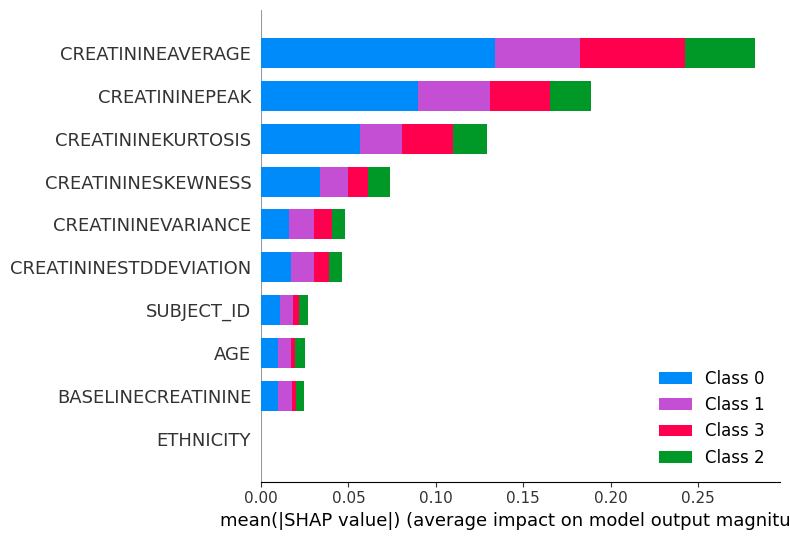

In [14]:
import shap


shap.initjs()
explainer = shap.TreeExplainer(rfc)
sample = testing_features_data.sample(100)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, max_display = 10)
shap.force_plot(explainer.expected_value[0], shap_values[0], testing_features_data)
#shap_values = explainer.shap_values(testing_features_data)
#shap.force_plot(explainer.expected_value[1], shap_values[1], testing_features_data)

# Implementing StandardScaler for SVM

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics

# Reading CSV file

In [16]:
Features = pd.read_csv (r'D:/1_Swansea/1_Uni/1_Project/Understanding/dataset/DB1.csv')

# Feature Extraction

In [17]:
labels1 = Features.loc[:,'LABEL']
features1 = Features.iloc[:]

training_features, testing_features, training_labels, testing_labels = train_test_split(features1, labels1, test_size = 0.15, random_state = 42)

testing_features_data2 = pd.DataFrame(data=testing_features, index=None, columns=list(Features.columns[:]))

training_features = training_features.iloc[:,5:]
testing_features = testing_features.iloc[:,5:]

print('Training Features Shape:', training_features.shape)
print('Training Labels Shape:', training_labels.shape)
print('Testing Features Shape:', testing_features.shape)
print('Testing Labels Shape:', testing_labels.shape)

testing_features_data2.head()

Training Features Shape: (1115785, 8)
Training Labels Shape: (1115785,)
Testing Features Shape: (196904, 8)
Testing Labels Shape: (196904,)


,SUBJECT_ID,CHARTTIME,MAX,LABEL,GENDER,ETHNICITY,BASELINECREATININE,AGE,X1,X2,X3,X4,X5
627131,13033,2185-11-16 00:00:00,7.8,3,12841 M,0,0.839,33,7.2,7.8,7.8,7.8,7.8
774289,11262,2177-01-10 16:00:00,2.1,2,10111 M,0,0.965,75,1.8,2.1,1.9,1.9,1.9
438117,13033,2183-03-08 00:00:00,1.4,1,12841 M,0,0.839,33,1.4,1.4,1.4,1.4,1.4
1151765,27472,2124-09-12 08:00:00,0.7,0,31055 M,0,0.911,57,0.6,0.6,0.7,0.7,0.7
924632,17570,2182-10-25 16:00:00,1.1,0,17329 M,0,0.941,67,1.1,1.1,1.1,1.1,1.1


# Plotting the change in Creatinine 

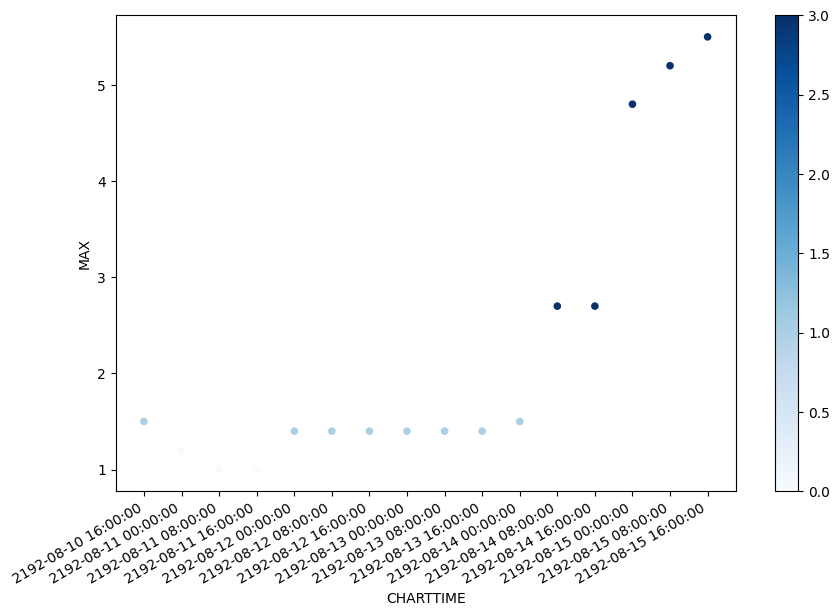

In [18]:
df = Features[(Features['SUBJECT_ID'] == 106)]
df1 = pd.DataFrame(df, columns=['CHARTTIME', 'MAX', 'LABEL'])
df1.plot(x ='CHARTTIME', y='MAX', kind = 'scatter', figsize=(10,7), c=df1.LABEL, cmap='Blues', sharex=False)
plt.gcf().autofmt_xdate()

In [19]:
import scipy.fft

fft_train = scipy.fft.fft(training_features)
fft_test = scipy.fft.fft(testing_features)

ifft_train = scipy.fft.ifft(fft_train)
ifft_test = scipy.fft.ifft(fft_test)

new_ifft_train = []
new_ifft_test = []

for i in ifft_train:
    i = i.real
    new_ifft_train.append(i)
    
for k in ifft_test:
    k = k.real
    new_ifft_test.append(k)

In [20]:
scale = StandardScaler()
fft_train_scaled = scale.fit_transform(new_ifft_train)
fft_test_scaled = scale.transform(new_ifft_test)



# Implementing Support Vector Classifier

In [21]:
modelsvc = SVC()
#modelsvc = SVC(probability = True)
modelsvc.fit(fft_train_scaled, training_labels)
predictedfft = (modelsvc.predict(fft_test_scaled))

print("Baseline Accuracy for SVM model: ", metrics.accuracy_score(testing_labels, predictedfft))



Baseline Accuracy for SVM model:  0.9770395725835941


In [22]:
print(modelsvc.predict(fft_test_scaled))

[3 2 1 ... 3 0 3]


# Implementing LIME for Support Vector Classifier

In [23]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(modelsvc)

from sklearn.metrics import f1_score, accuracy_score
from interpret.blackbox import LimeTabular
from interpret import show

lime = LimeTabular(predict_fn = modelsvc.predict, data = fft_test_scaled)
lime_local = lime.explain_local(fft_test_scaled[-20:],name='LIME')


show(lime_local)


<!-- http://127.0.0.1:7683/2153861463584/ -->

# Trying to Implementing ELI5 for Support Vector Classifier

In [26]:
import eli5 as eli

eli.explain_weights(modelsvc)
df2 = pd.DataFrame.from_records(fft_test_scaled) 

df2.iloc[1:]
#eli.explain_prediction(rfc , testing_features_data[1])

eli.show_prediction(modelsvc, df2.iloc[20],
                    show_feature_values=True)





# Performing required changes for ELI5 in Support Vector Classifier

In [24]:
#modelsvc = SVC(kernel = 'linear', probability = True)
modelsvc = SVC(kernel = 'linear')
#modelsvc = SVC(probability = True)
modelsvc.fit(fft_train_scaled, training_labels)
predictedfft = (modelsvc.predict(fft_test_scaled))

print("Baseline Accuracy for SVM model: ", metrics.accuracy_score(testing_labels, predictedfft))


Baseline Accuracy for SVM model:  0.9629565676674928


# Trying to implement ELI5 for Support Vector Classifier

In [25]:
import eli5 as eli

eli.explain_weights(modelsvc)
df2 = pd.DataFrame.from_records(fft_test_scaled) 

df2.iloc[1:]
#eli.explain_prediction(rfc , testing_features_data[1])

eli.show_prediction(modelsvc, df2.iloc[20],
                    show_feature_values=True)



